<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/GAM_and_NAM_ver1_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# !pip install pygam

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.calibration import calibration_curve

from pygam import LogisticGAM, s
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# === Load and preprocess dataset ===

# Load the dataset from CSV file
data_df = pd.read_csv("diabetes.csv")

# Separate features and target
X = data_df.drop(columns=['Outcome'])  # Features (all except target)
y = data_df['Outcome']                 # Target labels (0 or 1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [70]:
data_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFun,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [71]:
from pygam import LogisticGAM, s
from pygam.terms import TermList

n_features = X_train_scaled.shape[1]

# Create an empty TermList and add terms with + operator
terms = s(0)
for i in range(1, n_features):
    terms += s(i)

gam = LogisticGAM(terms)
gam.fit(X_train_scaled, y_train)


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + intercept,
   tol=0.0001, verbose=False)

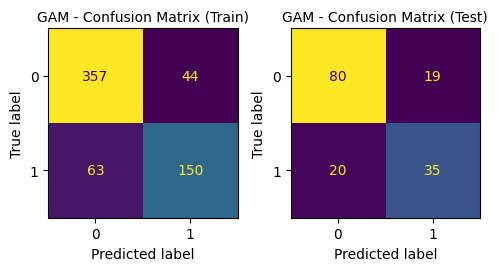

In [72]:
y_train_pred = gam.predict(X_train_scaled)
y_test_pred = gam.predict(X_test_scaled)
y_train_prob = gam.predict_proba(X_train_scaled)
y_test_prob = gam.predict_proba(X_test_scaled)

# === Helper metrics function ===
def calculate_metrics(y_true, y_pred):
    return [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    ]

metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Train": calculate_metrics(y_train, y_train_pred),
    "Test": calculate_metrics(y_test, y_test_pred)
}
metrics_df = pd.DataFrame(metrics_data)

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], colorbar=False)
axs[0].set_title("GAM - Confusion Matrix (Train)", fontsize=10)

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], colorbar=False)
axs[1].set_title("GAM - Confusion Matrix (Test)", fontsize=10)

plt.tight_layout()
plt.savefig("gam_confusion_matrices.png")
plt.show()

In [73]:
metrics_df.T

,0,1,2,3
Metric,Accuracy,Precision,Recall,F1 Score
Train,0.825733,0.773196,0.704225,0.737101
Test,0.746753,0.648148,0.636364,0.642202


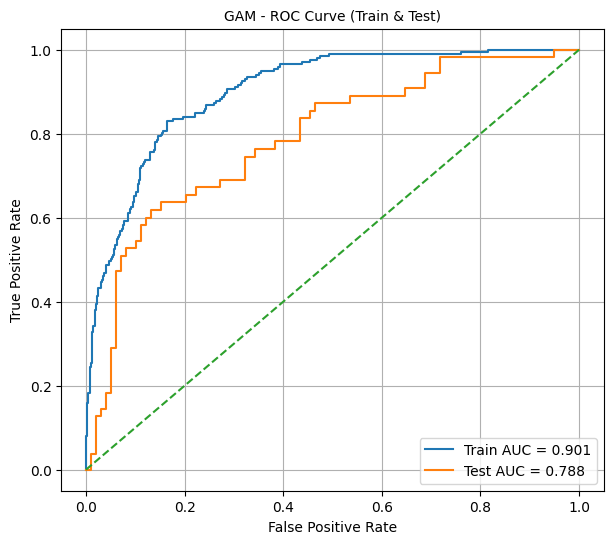

In [74]:
# === Plot ROC curves (Train and Test on one plot) ===
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_train:.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate", fontsize=10)
plt.ylabel("True Positive Rate", fontsize=10)
plt.title("GAM - ROC Curve (Train & Test)", fontsize=10)
plt.legend()
plt.grid(True)
plt.savefig("gam_roc_curve.png")
plt.show()

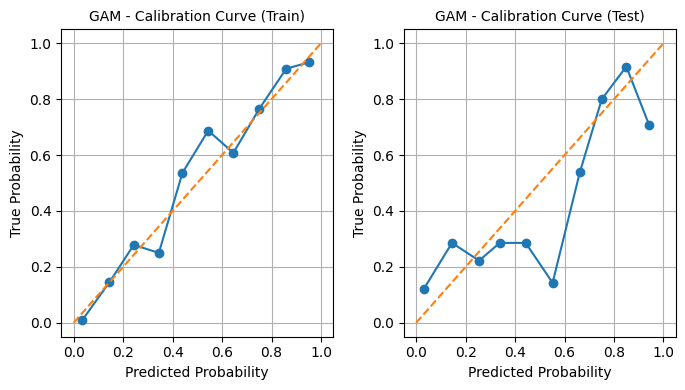

In [75]:
# === Calibration Curves (Train and Test side by side) ===
prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_prob, n_bins=10)
prob_true_test, prob_pred_test = calibration_curve(y_test, y_test_prob, n_bins=10)

fig, axs = plt.subplots(1, 2, figsize=(7,4))
axs[0].plot(prob_pred_train, prob_true_train, marker='o')
axs[0].plot([0, 1], [0, 1], '--')
axs[0].set_title("GAM - Calibration Curve (Train)", fontsize=10)
axs[0].set_xlabel("Predicted Probability", fontsize=10)
axs[0].set_ylabel("True Probability", fontsize=10)
axs[0].grid(True)

axs[1].plot(prob_pred_test, prob_true_test, marker='o')
axs[1].plot([0, 1], [0, 1], '--')
axs[1].set_title("GAM - Calibration Curve (Test)", fontsize=10)
axs[1].set_xlabel("Predicted Probability", fontsize=10)
axs[1].set_ylabel("True Probability", fontsize=10)
axs[1].grid(True)

plt.tight_layout()
plt.savefig("gam_calibration_curves.png")
plt.show()



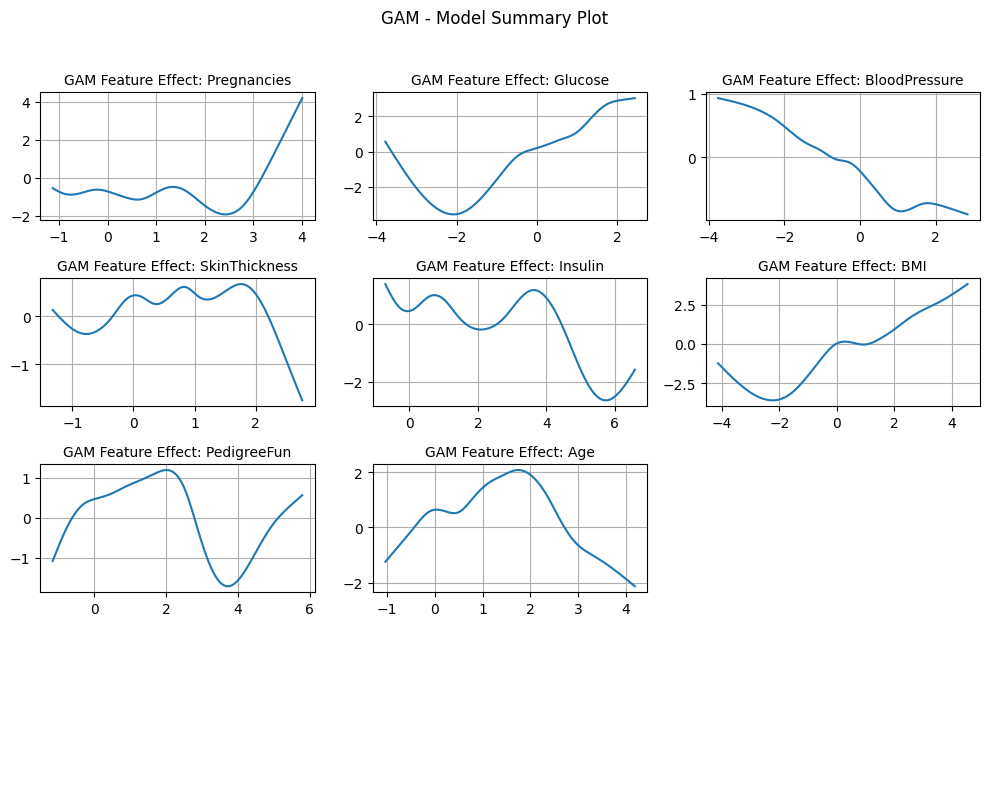

In [76]:
fig, axs = plt.subplots(4, 3, figsize=(10, 8))
axs = axs.ravel()

subplot_idx = 0
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    if subplot_idx >= len(axs):
        break
    XX = gam.generate_X_grid(term=i)
    axs[subplot_idx].plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    axs[subplot_idx].set_title(f"GAM Feature Effect: {X.columns[i]}", fontsize=10)
    axs[subplot_idx].grid(True)   # <-- Add grid here
    subplot_idx += 1

# Hide any remaining unused axes
for j in range(subplot_idx, len(axs)):
    axs[j].axis('off')

plt.suptitle("GAM - Model Summary Plot")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("gam_feature_effects_summary.png")
plt.show()


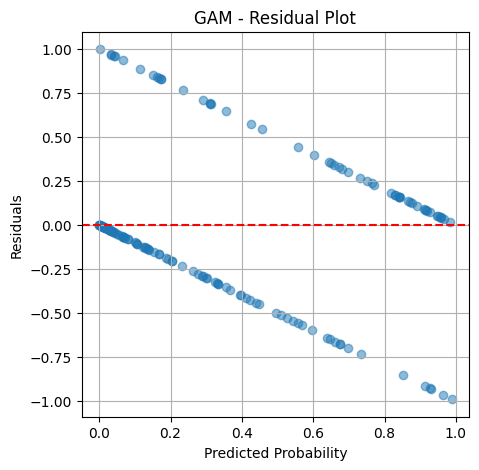

In [77]:
# === Residual Plot ===
residuals = y_test - y_test_prob
plt.figure(figsize=(5,5))
plt.scatter(y_test_prob, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("Residuals")
plt.title("GAM - Residual Plot")
plt.grid(True)
plt.savefig("gam_residual_plot.png")
plt.show()

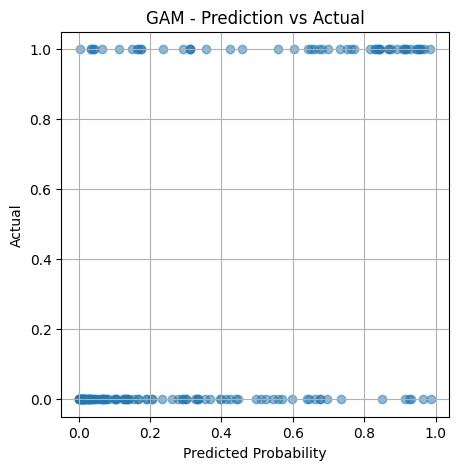

In [78]:
# === Prediction vs Actual ===
plt.figure(figsize=(5,5))
plt.scatter(y_test_prob, y_test, alpha=0.5)
plt.xlabel("Predicted Probability")
plt.ylabel("Actual")
plt.title("GAM - Prediction vs Actual")
plt.grid(True)
plt.savefig("gam_pred_vs_actual.png")
plt.show()


In [79]:
# === Neural Additive Model (NAM) Implementation ===

# Note: We build a simple NAM using PyTorch.
# Each feature gets its own small MLP to learn a univariate function.
# Their outputs are summed and passed through sigmoid for classification.

class SmallMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
    def forward(self, x):
        return self.net(x)

class NAM(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.models = nn.ModuleList([SmallMLP() for _ in range(input_dim)])
    def forward(self, x):
        # x shape: (batch_size, input_dim)
        outputs = []
        for i, model in enumerate(self.models):
            xi = x[:, i].unsqueeze(1)  # (batch_size, 1)
            out = model(xi)  # (batch_size, 1)
            outputs.append(out)
        return torch.sigmoid(torch.sum(torch.cat(outputs, dim=1), dim=1))  # sum over features

# Prepare tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nam = NAM(X_train_tensor.shape[1]).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(nam.parameters(), lr=0.01)

# Training loop
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    nam.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = nam(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        predicted = (preds > 0.5).float()
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
    train_losses.append(epoch_loss / total)
    train_accuracies.append(correct / total)

    # Evaluate on test set
    nam.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = nam(xb).squeeze()
            loss = criterion(preds, yb)
            test_loss += loss.item() * xb.size(0)
            predicted = (preds > 0.5).float()
            correct_test += (predicted == yb).sum().item()
            total_test += yb.size(0)
    test_losses.append(test_loss / total_test)
    test_accuracies.append(correct_test / total_test)

print(f"Training finished after {num_epochs} epochs")

Training finished after 50 epochs


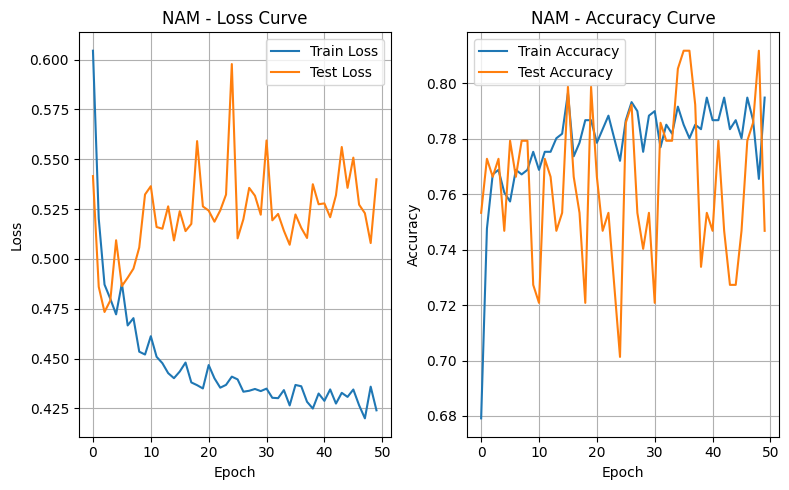

In [80]:
# Plot loss and accuracy curves
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_title("NAM - Loss Curve")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(train_accuracies, label='Train Accuracy')
axs[1].plot(test_accuracies, label='Test Accuracy')
axs[1].set_title("NAM - Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("nam_train_test_curves.png")
plt.show()

In [81]:
# Evaluate NAM final predictions on full train/test data
nam.eval()
with torch.no_grad():
    train_probs = nam(X_train_tensor.to(device)).cpu().numpy()
    test_probs = nam(X_test_tensor.to(device)).cpu().numpy()

train_preds = (train_probs > 0.5).astype(int)
test_preds = (test_probs > 0.5).astype(int)

# Calculate metrics for NAM
metrics_data_nam = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Train": calculate_metrics(y_train, train_preds),
    "Test": calculate_metrics(y_test, test_preds)
}
metrics_df_nam = pd.DataFrame(metrics_data_nam)
# print(metrics_df_nam.to_markdown(index=False))

metrics_df_nam.T

,0,1,2,3
Metric,Accuracy,Precision,Recall,F1 Score
Train,0.796417,0.689655,0.751174,0.719101
Test,0.746753,0.621212,0.745455,0.677686


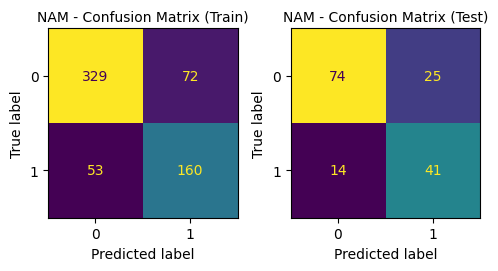

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_train, train_preds, ax=axs[0], colorbar=False)
axs[0].set_title("NAM - Confusion Matrix (Train)", fontsize=10)
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, ax=axs[1], colorbar=False)
axs[1].set_title("NAM - Confusion Matrix (Test)", fontsize=10)
plt.tight_layout()
plt.savefig("nam_confusion_matrices.png")
plt.show()

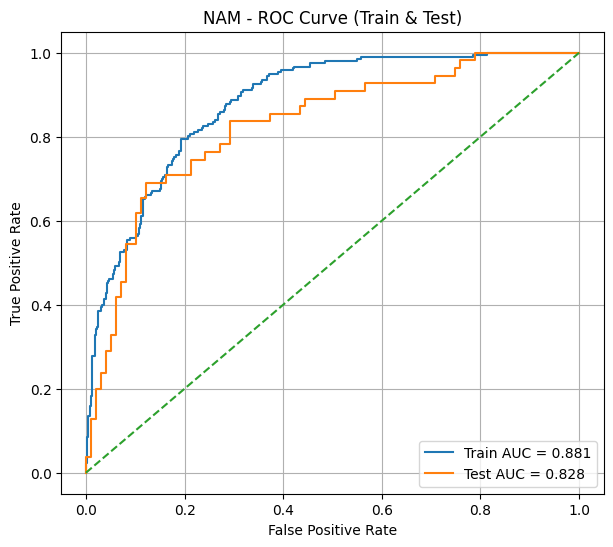

In [83]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_train_nam, tpr_train_nam, label=f"Train AUC = {roc_auc_train_nam:.3f}")
plt.plot(fpr_test_nam, tpr_test_nam, label=f"Test AUC = {roc_auc_test_nam:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("NAM - ROC Curve (Train & Test)")
plt.legend(loc='lower right')  # <-- legend at bottom right
plt.grid(True)
plt.savefig("nam_roc_curve.png")
plt.show()


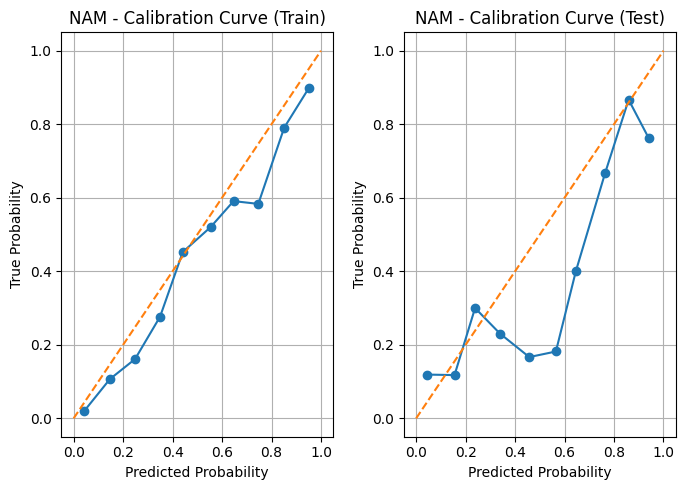

In [84]:
# Calibration Curves for NAM
prob_true_train_nam, prob_pred_train_nam = calibration_curve(y_train, train_probs, n_bins=10)
prob_true_test_nam, prob_pred_test_nam = calibration_curve(y_test, test_probs, n_bins=10)

fig, axs = plt.subplots(1, 2, figsize=(7,5))
axs[0].plot(prob_pred_train_nam, prob_true_train_nam, marker='o')
axs[0].plot([0, 1], [0, 1], '--')
axs[0].set_title("NAM - Calibration Curve (Train)")
axs[0].set_xlabel("Predicted Probability")
axs[0].set_ylabel("True Probability")
axs[0].grid(True)

axs[1].plot(prob_pred_test_nam, prob_true_test_nam, marker='o')
axs[1].plot([0, 1], [0, 1], '--')
axs[1].set_title("NAM - Calibration Curve (Test)")
axs[1].set_xlabel("Predicted Probability")
axs[1].set_ylabel("True Probability")
axs[1].grid(True)

plt.tight_layout()
plt.savefig("nam_calibration_curves.png")
plt.show()


In [87]:
import pandas as pd

# Suppose you already have these DataFrames:
# metrics_df  (GAM metrics, shape: 4 x 3, e.g., Metric, Train, Test)
# metrics_df_nam (NAM metrics, same shape)

# Transpose both
gam_metrics_T = metrics_df.T
nam_metrics_T = metrics_df_nam.T

# Rename columns for clarity
gam_metrics_T.columns = [f'GAM_{col}' for col in gam_metrics_T.columns]
nam_metrics_T.columns = [f'NAM_{col}' for col in nam_metrics_T.columns]

# Concatenate side-by-side (columns)
combined_metrics = pd.concat([gam_metrics_T, nam_metrics_T], axis=1)

combined_metrics


,GAM_0,GAM_1,GAM_2,GAM_3,NAM_0,NAM_1,NAM_2,NAM_3
Metric,Accuracy,Precision,Recall,F1 Score,Accuracy,Precision,Recall,F1 Score
Train,0.825733,0.773196,0.704225,0.737101,0.796417,0.689655,0.751174,0.719101
Test,0.746753,0.648148,0.636364,0.642202,0.746753,0.621212,0.745455,0.677686
